# TEST FACENET ON VGG TEST SET

**Import statements**

In [1]:
import os
import pandas as pd
import numpy as np
import cv2
from sklearn.metrics import accuracy_score, precision_score, recall_score
import tensorflow as tf
from tensorflow.keras.losses import CosineSimilarity
from keras_facenet import FaceNet
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

**Set up directories**

In [2]:
BASE_DIR = os.path.abspath(os.path.dirname("__file__"))
NUMPY_DIR = os.path.join(BASE_DIR, "data","numpy_arrays")

**Load face pair data for face verification**

In [3]:
X1 = np.load(os.path.join(NUMPY_DIR, "X1.npy"))
X2 = np.load(os.path.join(NUMPY_DIR, "X2.npy"))
y = np.load(os.path.join(NUMPY_DIR, "y.npy"))

## 1. Inspect sample positive and negative face pairs

### 1.1 Positive pairs

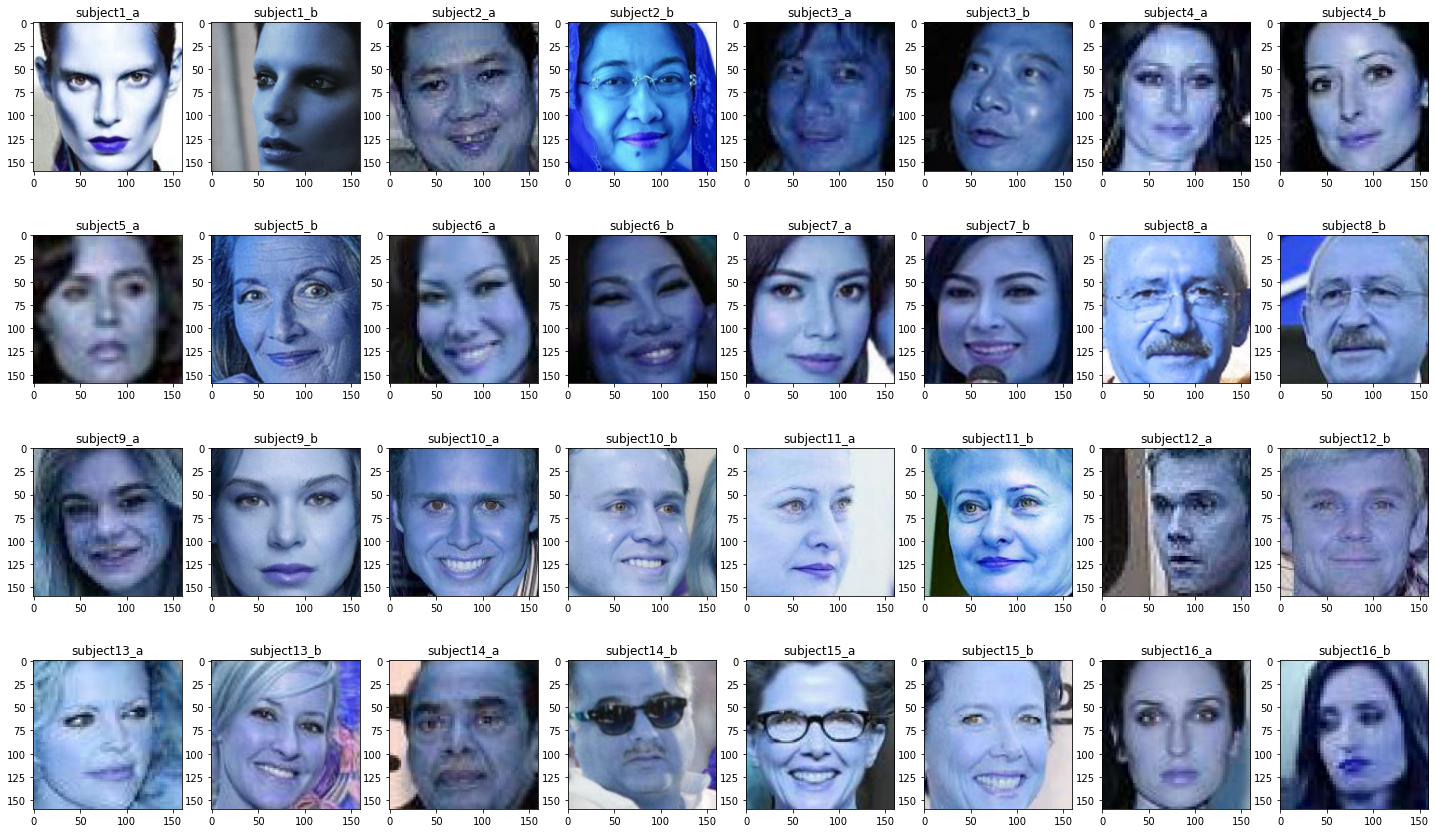

In [4]:
matplotlib.rcParams['figure.figsize'] = (25.0, 15.0)
indices = np.random.randint(0, high=X1.shape[0]//2, size=16, dtype=int).tolist()
pos_sample_1 = X1[indices]
pos_sample_2 = X2[indices]
for i in range(len(indices)):
    plt.subplot(4,8,i*2+1)
    plt.title("subject{}_a".format(i+1))
    plt.imshow(pos_sample_1[i].astype("uint8"))
    plt.subplot(4,8,i*2+2)
    plt.title("subject{}_b".format(i+1))
    plt.imshow(pos_sample_2[i].astype("uint8"))
plt.show()

## 1.2 Negative pairs

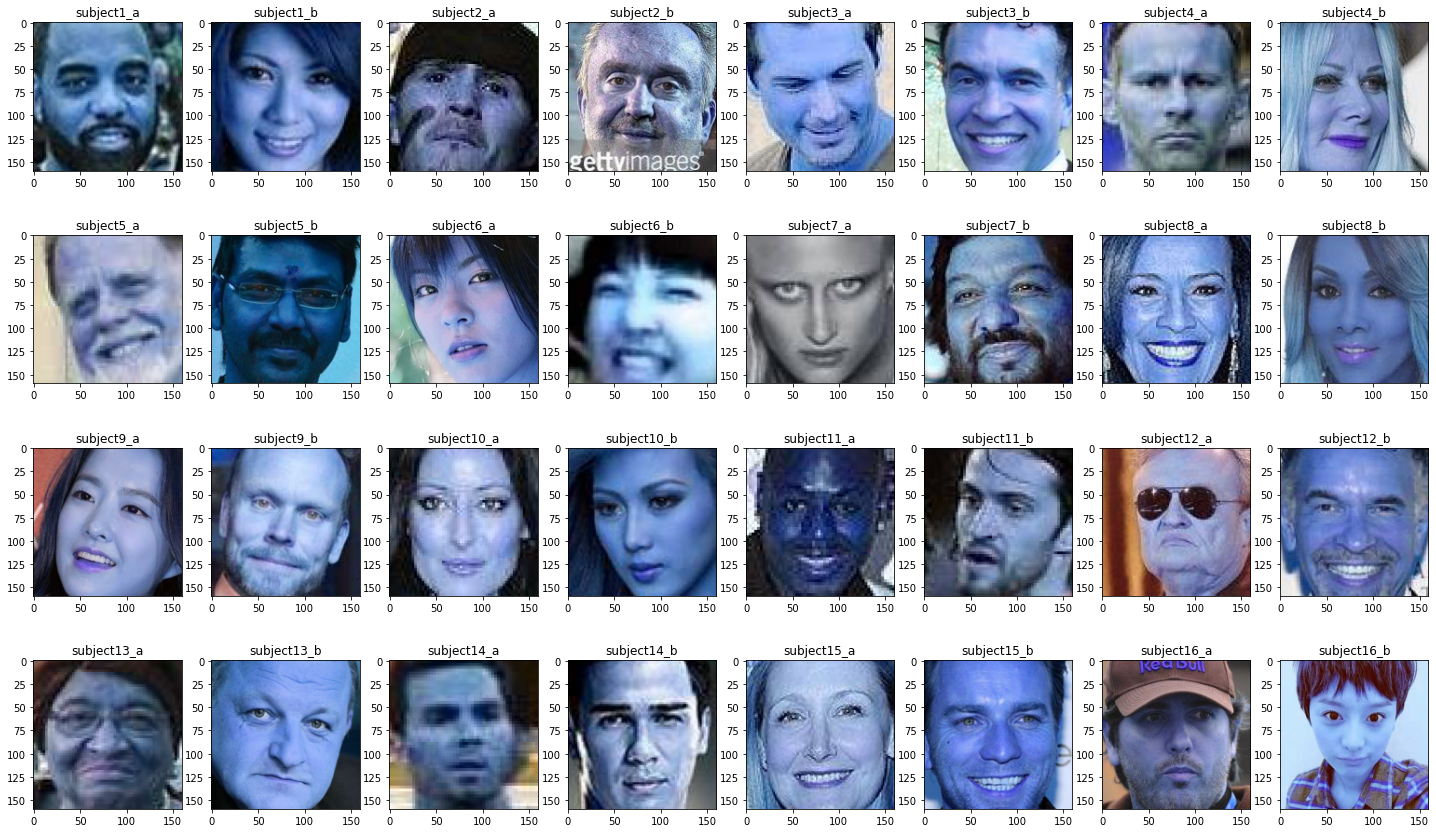

In [5]:
matplotlib.rcParams['figure.figsize'] = (25.0, 15.0)
indices = np.random.randint(X1.shape[0]//2, high=X1.shape[0], size=16, dtype=int).tolist()
pos_sample_1 = X1[indices]
pos_sample_2 = X2[indices]
for i- in range(len(indices)):
    plt.subplot(4,8,i*2+1)
    plt.title("subject{}_a".format(i+1))
    plt.imshow(pos_sample_1[i].astype("uint8"))
    plt.subplot(4,8,i*2+2)
    plt.title("subject{}_b".format(i+1))
    plt.imshow(pos_sample_2[i].astype("uint8"))
plt.show()

## 2. Inspect distribution of cosine similarity of +ve and -ve pairs

### 2.1 Generate embeddings of +ve and -ve pairs

**Load facenet embedder**

In [6]:
embedder = FaceNet()

**Generate embeddings**

In [7]:
length = len(X1)//2
X1_positive_embed = embedder.embeddings(X1[:length])
X2_positive_embed = embedder.embeddings(X2[:length])
X1_negative_embed = embedder.embeddings(X1[length:])
X2_negative_embed = embedder.embeddings(X2[length:])

**L2 normalize embeddings**

In [8]:
def l2_normalize(x, axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
    return output

for n in range(len(X1_positive_embed)):
    X1_positive_embed[n] = l2_normalize(X1_positive_embed[n])
for n in range(len(X2_positive_embed)):
    X2_positive_embed[n] = l2_normalize(X2_positive_embed[n])
for n in range(len(X1_negative_embed)):
    X1_negative_embed[n] = l2_normalize(X1_negative_embed[n])
for n in range(len(X2_negative_embed)):
    X2_negative_embed[n] = l2_normalize(X2_negative_embed[n])

### 2.2 Inspect distribution of cosine similarity

**Generate cosine similarity for +ve and -ve pairs**

In [9]:
cosine_loss = CosineSimilarity(axis=1, reduction=tf.keras.losses.Reduction.NONE)
cosine_pos = cosine_loss(X1_positive_embed, X2_positive_embed)
cosine_neg = cosine_loss(X1_negative_embed, X2_negative_embed)

**Inspect distribution of +ve and -ve pairs**

/home/ssl/anaconda3/envs/multi_face_recognizer/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ssl/anaconda3/envs/multi_face_recognizer/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


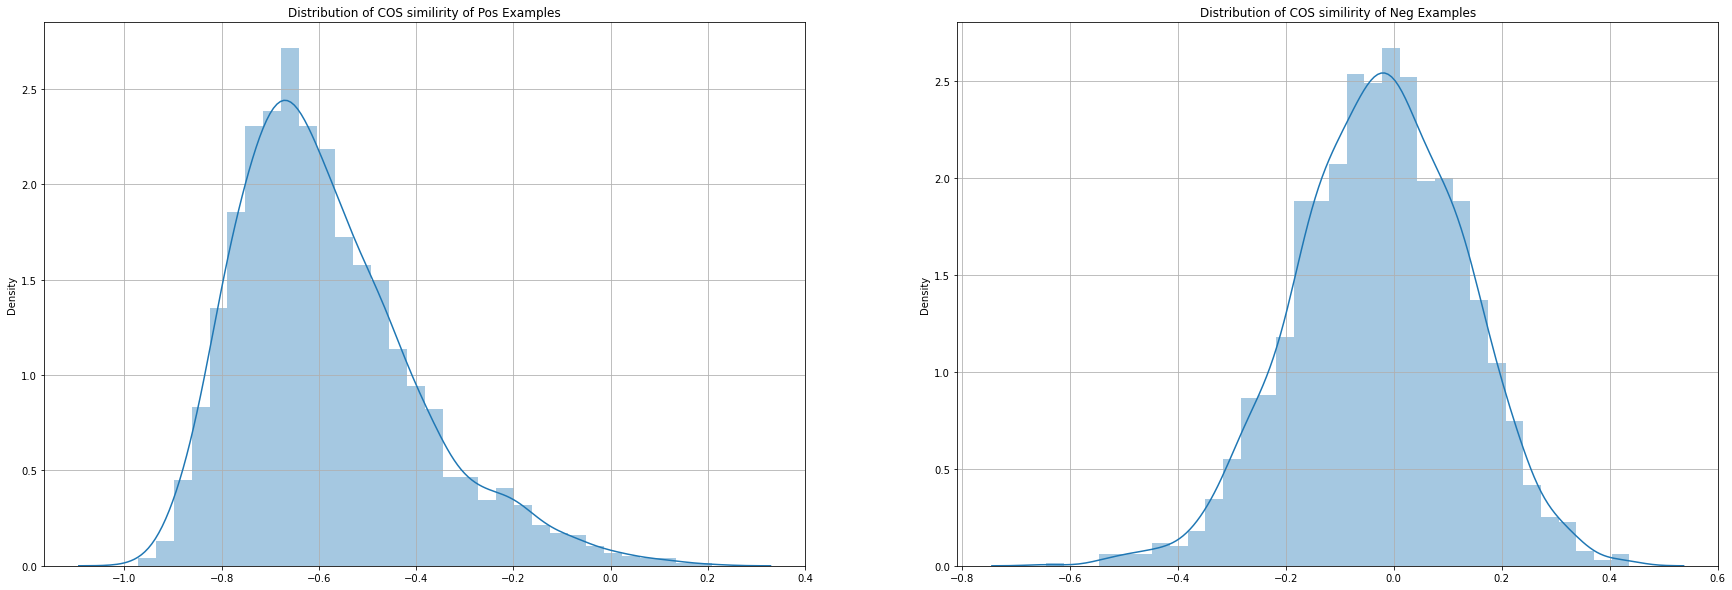

In [10]:
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
fig = sns.distplot(cosine_pos)
fig.grid(True)
fig.set_title("Distribution of COS similirity of Pos Examples")
plt.subplot(1,2,2)
fig = sns.distplot(cosine_neg)
fig.grid(True)
fig.set_title("Distribution of COS similirity of Neg Examples")
plt.show()

**Mean and std of cosine similarity of +ve and -ve pairs**

In [11]:
print("positive mean:", np.mean(cosine_pos))
print("positive std:", np.std(cosine_pos))
print("negative mean:", np.mean(cosine_neg))
print("negative std:", np.std(cosine_neg))

positive mean: -0.5835675
positive std: 0.18586536
negative mean: -0.02587805
negative std: 0.15401681


## 3. Performance tune facenet for face verification

**Generate face embeddings for the entire pairs**

In [12]:
X1_embed = embedder.embeddings(X1)
X2_embed = embedder.embeddings(X2)
for n in range(len(X1_embed)):
    X1_embed[n] = l2_normalize(X1_embed[n])
for n in range(len(X2_embed)):
    X2_embed[n] = l2_normalize(X2_embed[n])
loss = cosine_loss(X1_embed, X2_embed)

### 3.1 Collect results for a range of prediction thresholds

In [13]:
def compute_metrics(threshold, loss,y):
    """
    A fucntion to compute accuracy precision and recall for a given threshold
    """
    y_ = []
    for logit in np.array(loss):
        if logit<=threshold:
            y_.append(1)
        else:
            y_.append(0)
    y_ = np.array(y_)
    return accuracy_score(y, y_), precision_score(y, y_), recall_score(y, y_)

In [14]:
thresholds = np.linspace(-0.8, 0.2, 1000)
accuracies = []
precisions = []
recalls = []

for threshold in thresholds:
    accuracy, precision, recall = compute_metrics(threshold, loss,y)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    
results = pd.DataFrame({"threshold": thresholds,
                        "accuracy":accuracies,
                        "precision": precisions,
                        "recall": recalls})

**Inspect a filtered results**

In [22]:
results[(results.precision>=0.98) & (results.accuracy>=0.93)].\
sort_values(["precision", "accuracy"], ascending = False)

,threshold,accuracy,precision,recall
436,-0.363564,0.931641,0.982533,0.878906
434,-0.365566,0.930908,0.982504,0.877441
435,-0.364565,0.930908,0.982504,0.877441
433,-0.366567,0.930664,0.982495,0.876953
432,-0.367568,0.930176,0.982475,0.875977
437,-0.362563,0.931641,0.982007,0.879395
438,-0.361562,0.931641,0.982007,0.879395
439,-0.360561,0.931641,0.981481,0.879883
442,-0.357558,0.932373,0.980467,0.882324
441,-0.358559,0.931885,0.980445,0.881348


### 3.2 Precision/Accuracy/Recall vs Prediction Threshold Plot

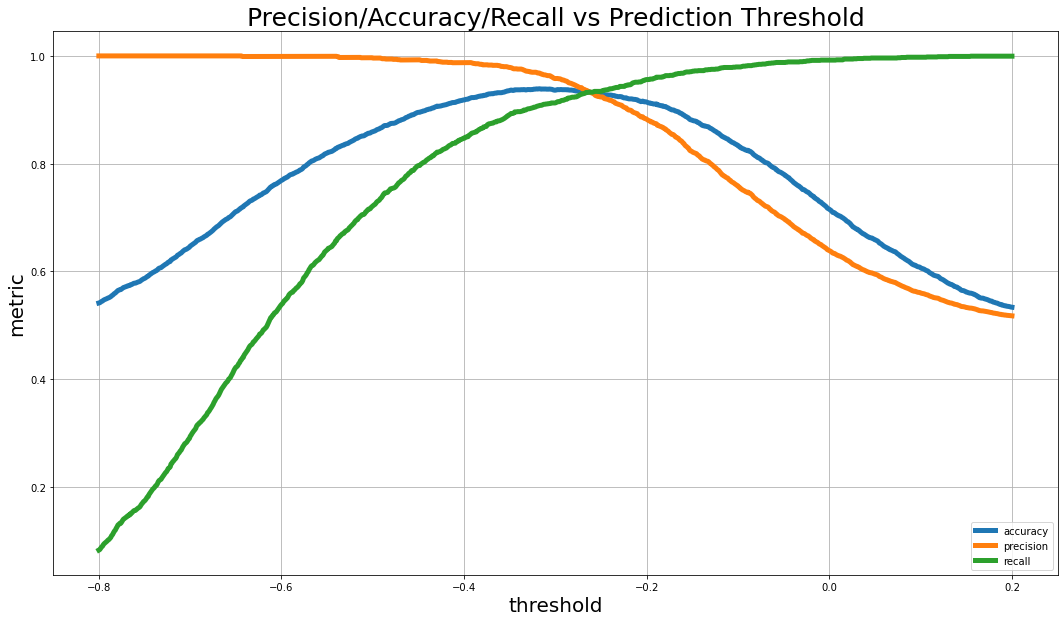

In [27]:
plt.figure(figsize=(18,10))
plt.plot(thresholds, accuracies, label = "accuracy", linewidth = 5)
plt.plot(thresholds, precisions, label = "precision", linewidth = 5)
plt.plot(thresholds, recalls, label = "recall", linewidth = 5)
plt.grid(True)
plt.xlabel("threshold", fontsize = 20)
plt.ylabel("metric", fontsize = 20)
plt.title("Precision/Accuracy/Recall vs Prediction Threshold", fontsize =25)
plt.legend()
plt.show()